In [1]:
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from datetime import datetime
import distutils.dir_util
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical
import numpy as np

from keras.layers import Dense, Input, Lambda, BatchNormalization, Conv2D, Dropout
from keras.layers import ZeroPadding2D, MaxPooling2D, AveragePooling2D, Activation, Flatten
from keras.layers import GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

from keras import __version__
print(__version__)

Using TensorFlow backend.


2.0.3


In [2]:
base_model = VGG16(weights='imagenet', include_top=False)

In [147]:
# get data for visualisation later

from keras.preprocessing.image import ImageDataGenerator
def preprocess_input2(x, data_format=None):
    """Preprocesses a tensor encoding a batch of images.
    # Arguments
        x: input Numpy tensor, 4D.
        data_format: data format of the image tensor.
    # Returns
        Preprocessed tensor.
    """

    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

#batch_size = 32

train_generator = train_datagen.flow_from_directory(
        '/home/ubuntu/data/fishing/train',
        target_size=(360, 640),
        batch_size=28,
        #batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        '/home/ubuntu/data/fishing/valid',
        target_size=(360, 640),
        shuffle=False,
        #batch_size=batch_size,
        batch_size=10,
        class_mode='categorical')

Found 3276 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


In [4]:
def create_precomputed_data(model, batches):
    filenames = batches.filenames
    conv_features = model.predict_generator(batches, (batches.samples/batches.batch_size ), verbose=1)
    labels_onehot = to_categorical(batches.classes)
    labels = batches.classes
    return (filenames, conv_features, labels_onehot, labels)

In [151]:
3276./28.

base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [6]:
## NB was having trouble visualising the resnet conv layer, unsure if the dimensions are suitable, so 
# came back to vgg - trying here to precompute the convolution layers for vgg but getting OOM error, reduced the batch 
# size and checked that nothing was trainable - that shouldn't matter just for prediction though.. 

In [7]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [8]:
base_model.layers.pop()
layers = base_model.layers
for l in layers:
    l.trainable = False

In [12]:
RESULTS_DIR = '/home/ubuntu/data/fishing/results'

In [13]:
import bcolz
def load_array(fname):
    return bcolz.open(fname)[:]

def load_precomputed_data(features_base_name="VGG16_640_conv_feats/trn_"):
    filenames = load_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat').tolist()
    conv_feats = load_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat')
    labels = load_array(RESULTS_DIR+"/"+features_base_name+'labels.dat')
    return filenames, conv_feats, labels

trn_filenames, trn_conv_features, trn_labels = load_precomputed_data("VGG16_640_conv_feats/trn_")
val_filenames, val_conv_features, val_labels = load_precomputed_data("VGG16_640_conv_feats/val_")
test_filenames, test_conv_features, test_labels = load_precomputed_data("VGG16_640_conv_feats/test_")

In [10]:
# trn_filenames, trn_conv_features, trn_labels, trn_labels_1 = create_precomputed_data(base_model, train_generator)
# val_filenames, val_conv_features, val_labels, val_labels_1 = create_precomputed_data(base_model, validation_generator)

In [14]:
len(trn_filenames), trn_conv_features.shape, len(trn_labels)

(3276, (3276, 11, 20, 512), 3276)

In [15]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [16]:
#classifier_input_shape = resnet_base.layers[-1].output_shape[1:] 
# i.e. shape of conv features (produces (None, None, None, 2048))
classifier_input_shape = (11, 20, 512)
# classifier_input_shape = resnet_base.layers[-1].output_shape[1:]
classifier_input = Input(shape=classifier_input_shape)

In [17]:
# Create classifier model

x= Flatten()(classifier_input)
x = Dense(8, activation='softmax')(x)
                                                     
classifier_model_v1 = Model(classifier_input, x)

#from keras.optimizers import SGD
classifier_model_v1.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
classifier_model_v1.fit(trn_conv_features, trn_labels,
                                          batch_size=32, 
                                          epochs=5,
                                          validation_data=(val_conv_features, val_labels),
                                          shuffle=True)

# ran 3 times

Train on 3276 samples, validate on 500 samples
Epoch 1/5
3276/3276 [==============================] - 2s - loss: 0.8122 - acc: 0.7524 - val_loss: 0.4043 - val_acc: 0.8860
Epoch 2/5
3276/3276 [==============================] - 1s - loss: 0.2582 - acc: 0.9393 - val_loss: 0.2702 - val_acc: 0.9120
Epoch 3/5
3276/3276 [==============================] - 1s - loss: 0.1432 - acc: 0.9719 - val_loss: 0.2341 - val_acc: 0.9540
Epoch 4/5
3276/3276 [==============================] - 1s - loss: 0.0888 - acc: 0.9884 - val_loss: 0.1829 - val_acc: 0.9580
Epoch 5/5
3276/3276 [==============================] - 1s - loss: 0.0584 - acc: 0.9948 - val_loss: 0.1534 - val_acc: 0.9660


In [21]:
nf = 128
p = 0.

# x = Flatten(input_shape=classifier_input_shape)(classifier_input)
x = Conv2D(nf,(3,3), activation='relu', padding='same')(classifier_input)
x = BatchNormalization(axis=1)(x)
x = Conv2D(nf,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=1)(x)
x = Conv2D(8,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax')(x)

classifier_model_v2 = Model(classifier_input, x)

classifier_model_v2.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [137]:
classifier_model_v2.fit(trn_conv_features, trn_labels, 
                                          batch_size=32, 
                                          epochs=5,
                                          validation_data=(val_conv_features,val_labels),
                                          shuffle=True)

# ran 5 times

Train on 3276 samples, validate on 500 samples
Epoch 1/5
3276/3276 [==============================] - 21s - loss: 0.0330 - acc: 0.9945 - val_loss: 0.1799 - val_acc: 0.9500
Epoch 2/5
3276/3276 [==============================] - 21s - loss: 0.0371 - acc: 0.9921 - val_loss: 0.1996 - val_acc: 0.9440
Epoch 3/5
3276/3276 [==============================] - 20s - loss: 0.0235 - acc: 0.9979 - val_loss: 0.1452 - val_acc: 0.9520
Epoch 4/5
3276/3276 [==============================] - 20s - loss: 0.0648 - acc: 0.9829 - val_loss: 0.3540 - val_acc: 0.8900
Epoch 5/5
3276/3276 [==============================] - 20s - loss: 0.0271 - acc: 0.9957 - val_loss: 0.1420 - val_acc: 0.9560


In [54]:
l = classifier_model_v2.layers
input_layer = l[0]
last_conv_layer = l[-4]
conv_fn = K.function([input_layer.input, K.learning_phase()], [last_conv_layer.output])
# conv_fn = K.function([input_layer.input], [last_conv_layer.output])

In [55]:
classifier_model_v2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 11, 20, 512)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 20, 128)       589952    
_________________________________________________________________
batch_normalization_3 (Batch (None, 11, 20, 128)       44        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 20, 128)       147584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 11, 20, 128)       44        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 20, 8)         9224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 20, 8)         0         
__________

In [56]:
import scipy
def get_cm(imp, label):
    conv = conv_fn([imp,0])[0][0,:,:,label]
#     print(conv.shape)
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

In [122]:
image_num = 400

In [123]:
inp = np.expand_dims(val_conv_features[image_num],0)
np.round(classifier_model_v2.predict(inp)[0],2)

array([ 0.01      ,  0.01      ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.98000002,  0.        ], dtype=float32)

In [124]:
def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

In [131]:
label = 6
cm = get_cm(inp, label)

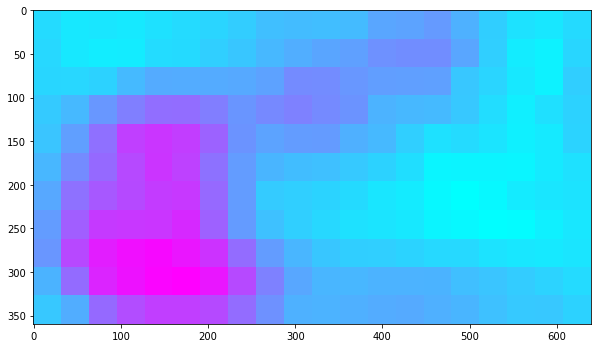

In [132]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(to_plot(cm), cmap="cool")

plt.show()

In [133]:
img_path = '/home/ubuntu/data/fishing/valid/'+ val_filenames[image_num]

In [134]:
import matplotlib.image as mpimg

img=mpimg.imread(img_path)

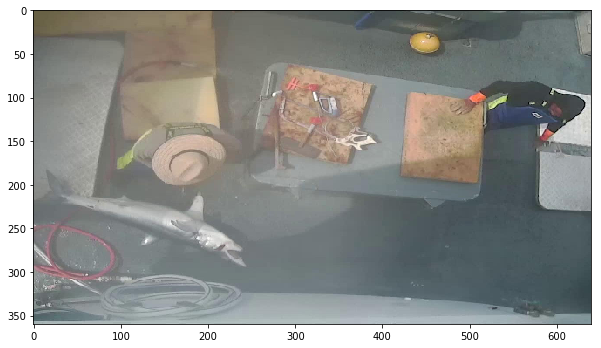

In [135]:
plt.figure(figsize=(10,10))
plt.imshow(scipy.misc.imresize(img, (360,640), interp='nearest'))
plt.show()

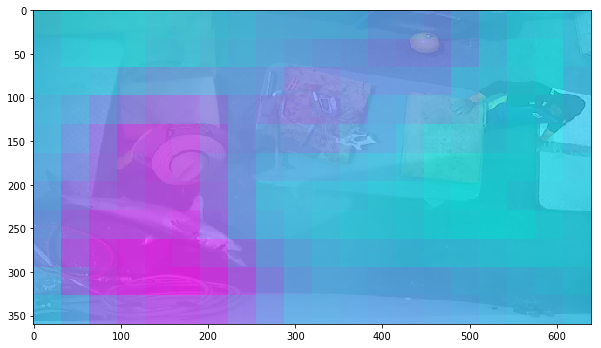

In [136]:
plt.figure(figsize=(10,10))
plt.imshow(scipy.misc.imresize(img, (360,640), interp='nearest'))
plt.imshow(to_plot(cm), cmap="cool", alpha=0.7)

plt.show()

## Generate and Validate Predictions

In [138]:
def do_clip(arr, mx, num_classes): return np.clip(arr, (1-mx)/(num_classes-1), mx)

In [140]:
DATA_ROOT_DIR = "/home/ubuntu/data/fishing/"
TEST_STG1_DIR = DATA_ROOT_DIR + '/test_stg1/'
TEST_STG2_DIR = DATA_ROOT_DIR + '/test_stg2/'
RESULTS_DIR = DATA_ROOT_DIR + '/results/'

In [152]:
# Create (Raw Image) Batches
def get_batches(path,
                gen=ImageDataGenerator(preprocessing_function=preprocess_input2),
                shuffle=True,
                batch_size=64,
                target_size=(360,640),
                class_mode='categorical'):
    return gen.flow_from_directory(path, 
                                   target_size=target_size,
                                   class_mode=class_mode,
                                   shuffle=shuffle, 
                                   batch_size=batch_size)

In [ ]:

# Get Data
test_stg1_batches = get_batches(TEST_STG1_DIR, batch_size=1, shuffle=False)
test_stg2_batches = get_batches(TEST_STG2_DIR, batch_size=1, shuffle=False)

class_predictions = []

#for one_image in test_batches:
for _ in range(len(test_stg1_batches.filenames)):
    ##print(one_image[0].shape)
    #print(test_batches.next()[0].shape)
    one_image = test_stg1_batches.next()[0]
    
    test_conv_features = base_model.predict(one_image, batch_size=1, verbose=1)
    prediction = classifier_model_v2.predict(test_conv_features, batch_size=1, verbose=1)
    class_predictions.append(prediction)

#for one_image in test_batches:
for _ in range(len(test_stg2_batches.filenames)):
    ##print(one_image[0].shape)
    #print(test_batches.next()[0].shape)
    one_image = test_stg2_batches.next()[0]
    
    test_conv_features = base_model.predict(one_image, batch_size=1, verbose=1)
    prediction = classifier_model_v2.predict(test_conv_features, batch_size=1, verbose=1)
    class_predictions.append(prediction)
    
assert len(class_predictions) == 13153, "The number in of predictions created is not equal to the number in test_stg2"

Found 1000 images belonging to 1 classes.
Found 12153 images belonging to 1 classes.
1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


In [ ]:
preds = np.array(class_predictions)

subm = do_clip(preds, 0.82, 8)
subm_name = RESULTS_DIR+'resnet50_bb_v1/subm_bb.csv'
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [ ]:
import pandas as pd

submission = pd.DataFrame(np.squeeze(subm), columns=classes)
submission.insert(0, 'image', test_stg1_batches.filenames + test_stg2_batches.filenames)
submission.head()

In [ ]:
submission.tail()

In [ ]:
submission.to_csv(subm_name, index=False)#, header=False)#, compression='gzip')

In [ ]:
subm_name_stg1 = RESULTS_DIR+'classifier_model_v2/subm_bb_test_stg1.csv'
subm_name_stg2 = RESULTS_DIR+'classifier_model_v2/subm_bb_test_stg2.csv'
subm_nameFIXED = RESULTS_DIR+'classifier_model_v2/subm_bbFIXED.csv'

!head -n +1001 $subm_name | sed "s:^unknown/::g" > $subm_name_stg1
!tail -n +1002 $subm_name | sed "s:^unknown:test_stg2:g" > $subm_name_stg2
!cat $subm_name_stg1 $subm_name_stg2 > $subm_nameFIXED